### Updated on 12-May-2021
<h4> Parallel Format </h4>
<br>
This notebook implements the three party Quantum Conference Protocol

In [1]:
from qiskit import *
from qiskit.compiler import transpile, assemble
from qiskit.tools.jupyter import *
from qiskit.visualization import *
import matplotlib.pyplot as plotter
import numpy as np
from IPython.display import display, Math, Latex, Image
%matplotlib inline

Now here our Message length will be 8 and Delta_m is 2

In [2]:
num_bits = 8

key_ini = np.random.randint(2, size = num_bits)

alice_mess_ini = np.random.randint(2, size = num_bits)
bob_mess_ini = np.random.randint(2, size = num_bits)
charlie_mess_ini = np.random.randint(2, size = num_bits)

delta_m = 2

common_idx = np.sort(np.random.choice(num_bits, size = delta_m, replace = False))

qa_ini = np.random.choice(num_bits, size = num_bits, replace = False)
qb_ini = np.random.choice(num_bits, size = num_bits, replace = False)
qc_ini = np.random.choice(num_bits, size = num_bits, replace = False)


In [3]:
def encode_message(key_bit, message_bit, qubit, circuit):
    if message_bit == 1:
        circuit.x(qubit)
    if key_bit == 1:
        circuit.h(qubit)
    return circuit

def run_circuit(qc, shot):
    backend = Aer.get_backend('qasm_simulator') 
    result = execute(qc, backend, shots = shot).result() 
    counts = result.get_counts()
    return counts

def count_to_str(counts):
    r = counts.items()
    for res, shots in r:
        result = str(res)
    return result

Now here first the circuit is generated

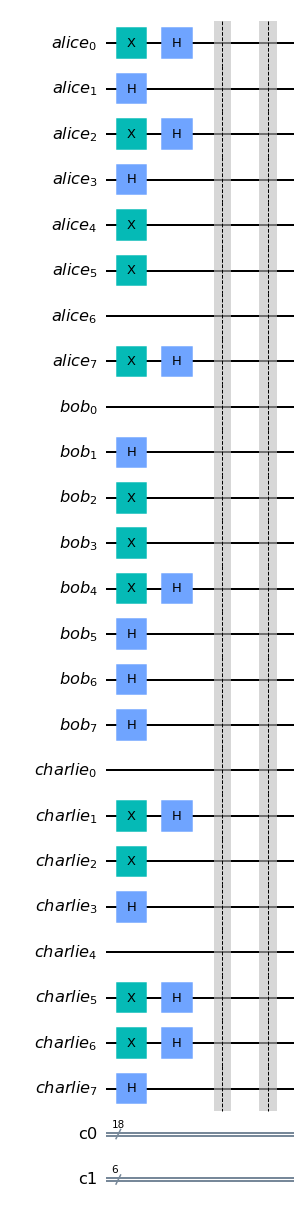

In [4]:

alice = QuantumRegister(num_bits, "alice")
bob = QuantumRegister(num_bits, "bob")
charlie = QuantumRegister(num_bits, "charlie")
ufp1 = ClassicalRegister(3*num_bits - 3*delta_m)
ufp2 = ClassicalRegister(3*delta_m)

circuit = QuantumCircuit(alice, bob, charlie, ufp1, ufp2)

for i in range(num_bits):
    
    k = key_ini[i]
    a = alice_mess_ini[i]
    b = bob_mess_ini[i]
    c = charlie_mess_ini[i]
    
    a_idx = qa_ini[i]
    b_idx = qb_ini[i]
    c_idx = qc_ini[i]
        
    encode_message(k, a, alice[a_idx], circuit)
    encode_message(k, b, bob[b_idx], circuit)
    encode_message(k, c, charlie[c_idx], circuit)

circuit.barrier()

#Any Eaves Dropper Action can be executed here 

circuit.barrier()

circuit.draw(output = 'mpl')

Now next the security of the bits is checked 

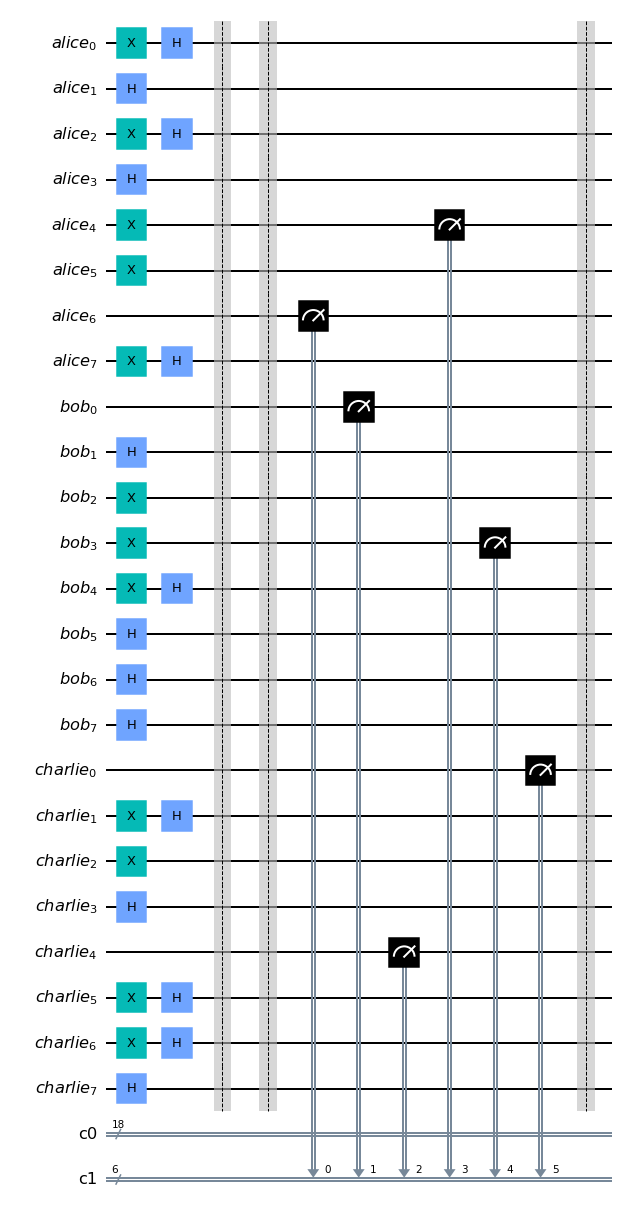

In [5]:
for i in range(delta_m):
    
    idx = common_idx[i]
    a_idx = qa_ini[idx]
    b_idx = qb_ini[idx]
    c_idx = qc_ini[idx] 
    
    k = key_ini[idx]

    if k == 1 :
        circuit.h([alice[a_idx], bob[b_idx], charlie[c_idx]])
    
    circuit.measure([alice[a_idx], bob[b_idx], charlie[c_idx]], [ufp2[3*i], ufp2[3*i+1], ufp2[3*i+2]])

circuit.barrier()

count1 = run_circuit(circuit, 1)
ini_result = count_to_str(count1)
ini_result = ini_result[::-1]

ini_result = ini_result[3*(num_bits - delta_m) + 1:]

circuit.draw(output = "mpl")

In [6]:
flag = 1

for i in range(delta_m):
    
    a = (int)(ini_result[3*i])
    b = (int)(ini_result[3*i + 1])
    c = (int)(ini_result[3*i + 2])
    
    idx = common_idx[i]
    
    a_mess = alice_mess_ini[idx]
    b_mess = bob_mess_ini[idx]
    c_mess = charlie_mess_ini[idx]
    
    if a != a_mess or b != b_mess or c != c_mess:
        flag = 0

if flag == 1:
    print("UFP Channel Security Check Passed !")
else:
    print("UFP Channel Security Check Failed !")

UFP Channel Security Check Passed !


Now the Security has been checked 
<br>
Now the measurement by UFP will be done in GHZ basis

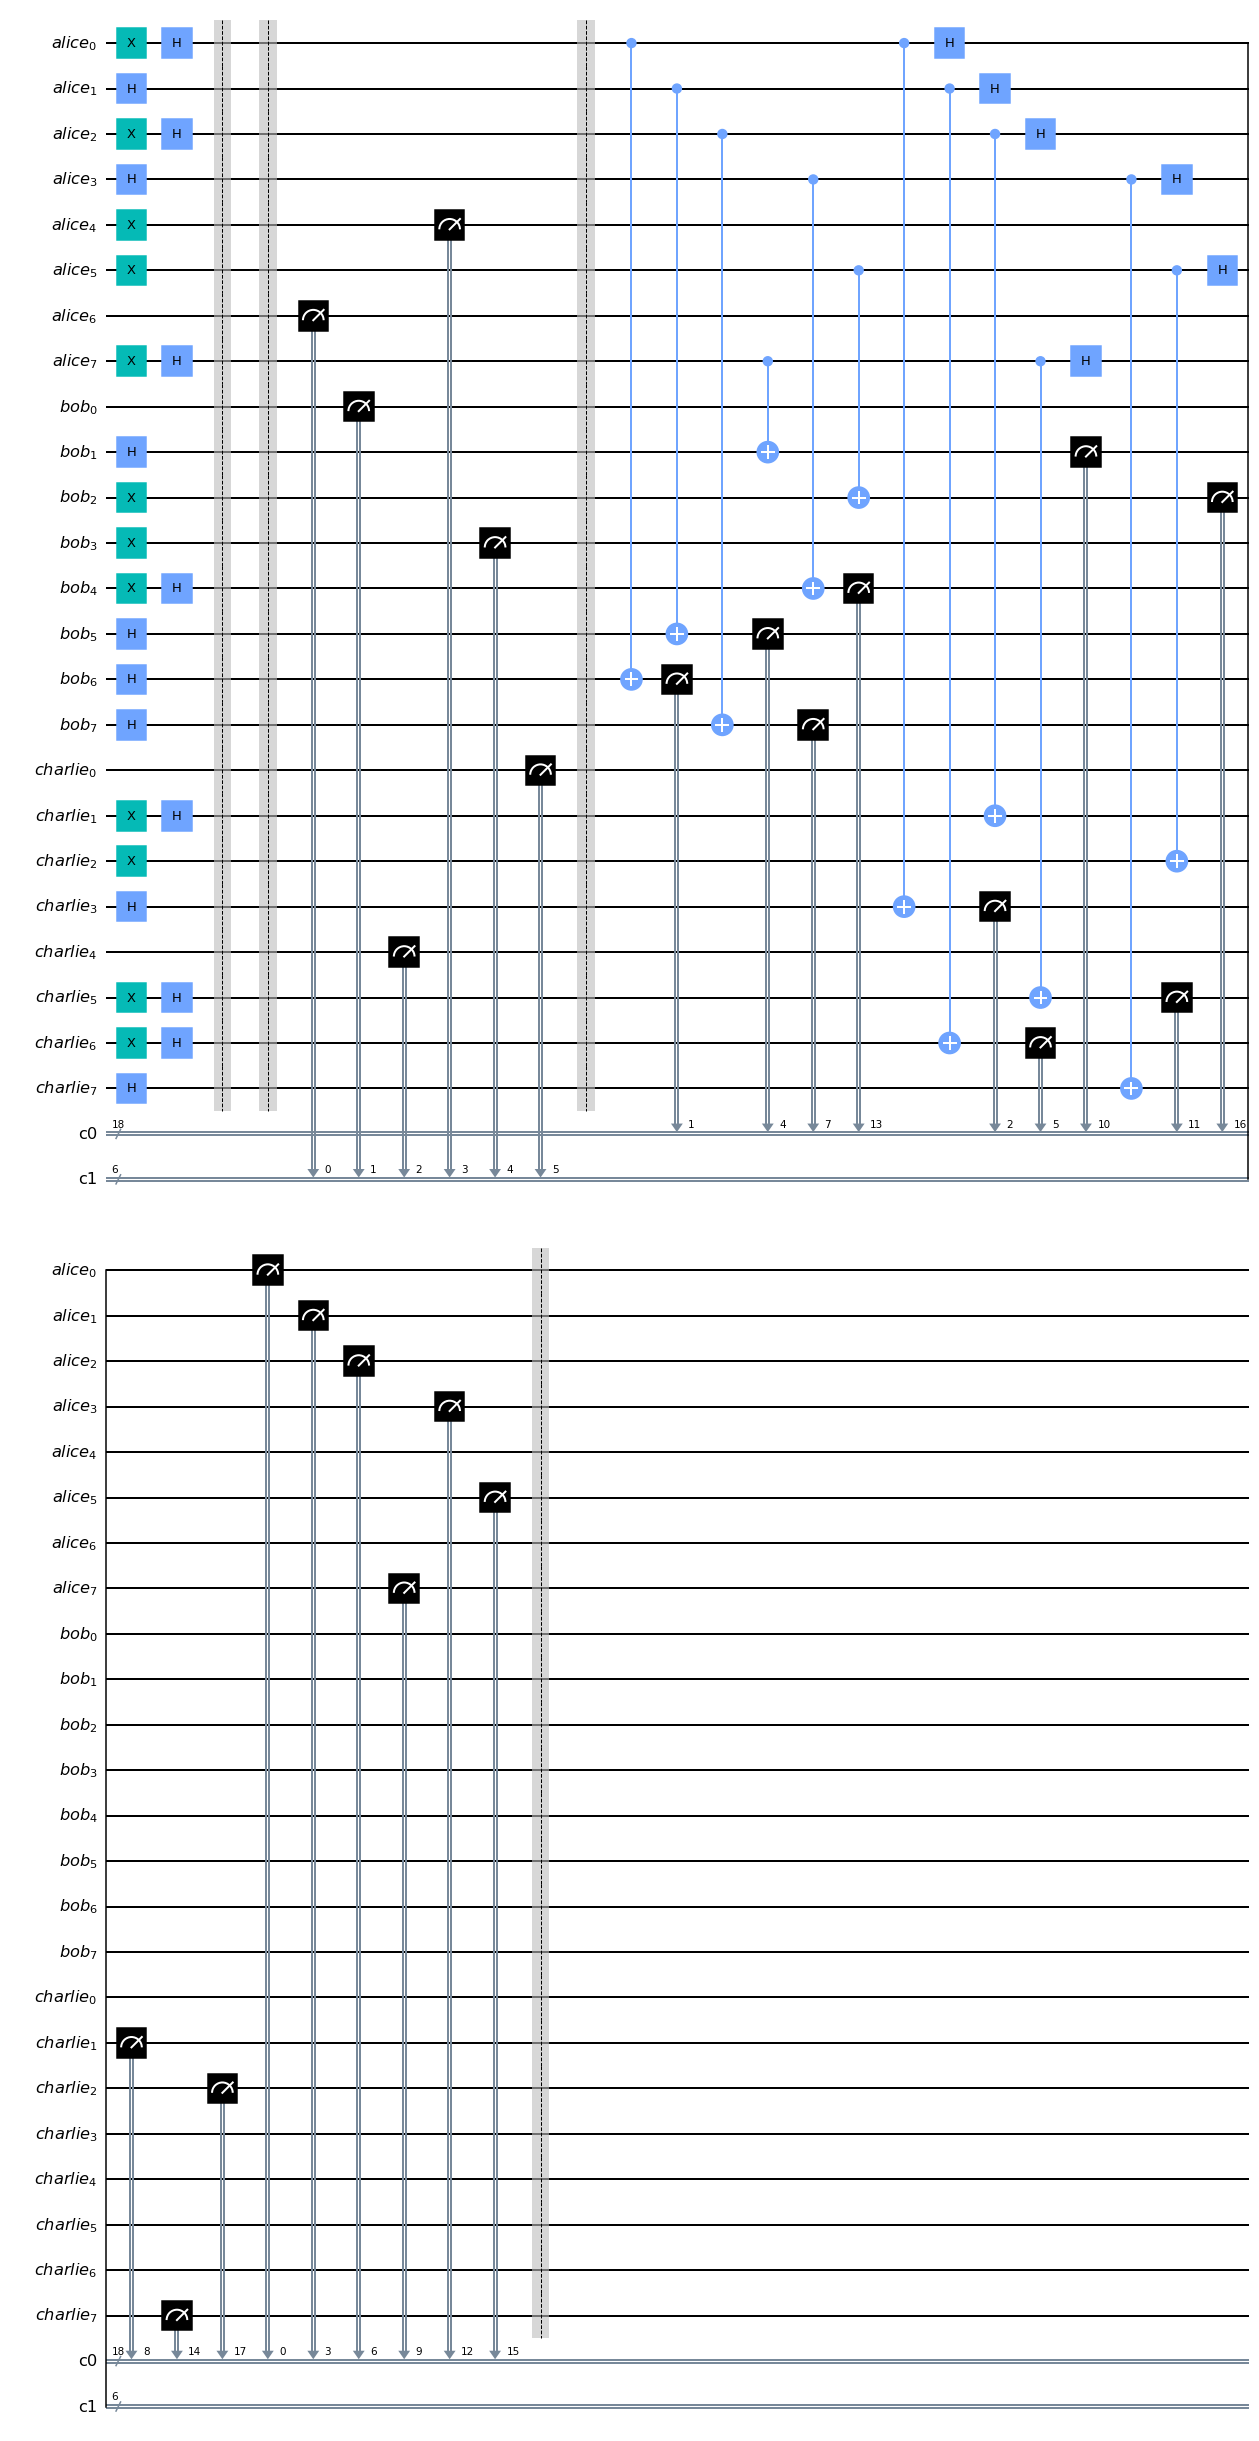

In [7]:
j = 0 

for i in range(num_bits):
    
    if i not in common_idx:
        
        a_idx = qa_ini[i]
        b_idx = qb_ini[i]
        c_idx = qc_ini[i]
            
        circuit.cx(alice[a_idx], bob[b_idx])
        circuit.cx(alice[a_idx], charlie[c_idx])
        circuit.h(alice[a_idx])
    
        circuit.measure([alice[a_idx], bob[b_idx], charlie[c_idx]], [ufp1[3*j], ufp1[3*j + 1], ufp1[3*j + 2]])
        j = j+1

circuit.barrier()
circuit.draw(output = "mpl")

Now Decoding of the results announced by UFP will be done each person

In [8]:
count = run_circuit(circuit, 1)
result = count_to_str(count)

result = result[::-1]
final_result = result[:3*(num_bits - delta_m)]

Now here the indexes used for security checking are removed

In [9]:
key = []
alice_mess = []
bob_mess = []
charlie_mess = []

for i in range(num_bits):
    if i not in common_idx:
        key.append(key_ini[i])
        alice_mess.append(alice_mess_ini[i])
        bob_mess.append(bob_mess_ini[i])
        charlie_mess.append(charlie_mess_ini[i])
        
key = np.array(key)
alice_mess = np.array(alice_mess)
bob_mess = np.array(bob_mess)
charlie_mess = np.array(charlie_mess)
new_num_bits = len(charlie_mess)

In [10]:
dec_a_for_b = np.empty(shape = new_num_bits, dtype = int)
dec_c_for_b = np.empty(shape = new_num_bits, dtype = int)

dec_a_for_c = np.empty(shape = new_num_bits, dtype = int)
dec_b_for_c = np.empty(shape = new_num_bits, dtype = int)

dec_b_for_a = np.empty(shape = new_num_bits, dtype = int)
dec_c_for_a = np.empty(shape = new_num_bits, dtype = int)

one_idx = []
alice_xor = []
bob_xor = []
charlie_xor = []

for i in range(new_num_bits):
    
    if key[i] == 0:
        
        a = (int)(final_result[3*i])
        b = (int)(final_result[3*i + 1])
        c = (int)(final_result[3*i + 2])
        if alice_mess[i] == 0:
            dec_b_for_a[i] = b 
            dec_c_for_a[i] = c
        else:
            dec_b_for_a[i] = 1 - b 
            dec_c_for_a[i] = 1 - c
        
        a = 0
        
        if bob_mess[i] == b:
            dec_a_for_b[i] = a
            dec_c_for_b[i] = c
        else :
            dec_a_for_b[i] = 1 - a
            dec_c_for_b[i] = 1 - c
        
        if charlie_mess[i] == c:
            dec_a_for_c[i] = a
            dec_b_for_c[i] = b
        else :
            dec_a_for_c[i] = 1 - a
            dec_b_for_c[i] = 1 - b
        
    else:
        one_idx.append(i)
        #Here where the key bit is 1 the XOR value of other two are stored     
        if alice_mess[i] == (int)(final_result[3*i]):
            alice_xor.append(0)
        else:
            alice_xor.append(1)
        if bob_mess[i] == (int)(final_result[3*i]):
            bob_xor.append(0)
        else:
            bob_xor.append(1)
        if charlie_mess[i] == (int)(final_result[3*i]):
            charlie_xor.append(0)
        else:
            charlie_xor.append(1)

In [11]:
num_decoy = 2

decoy_a_base = np.random.randint(2, size = num_decoy)
decoy_a_bit = np.random.randint(2, size = num_decoy)

decoy_b_base = np.random.randint(2, size = num_decoy)
decoy_b_bit = np.random.randint(2, size = num_decoy)

decoy_c_base = np.random.randint(2, size = num_decoy)
decoy_c_bit = np.random.randint(2, size = num_decoy)

num_xor_total = num_decoy + len(one_idx)

sa = np.random.choice(num_xor_total, size = num_xor_total, replace = False)
sb = np.random.choice(num_xor_total, size = num_xor_total, replace = False)
sc = np.random.choice(num_xor_total, size = num_xor_total, replace = False)

decoy_a_idx = np.sort(np.random.choice(num_xor_total, size = num_decoy, replace = False))
decoy_b_idx = np.sort(np.random.choice(num_xor_total, size = num_decoy, replace = False))
decoy_c_idx = np.sort(np.random.choice(num_xor_total, size = num_decoy, replace = False))

Now the part with UFP is done <br>
One by One the Qubits will be prepared and will be send from <br>
1. Alice to Bob <br>
2. Bob to Charlie <br>
3. Charlie to Alice <br>
Here first the security of each channel will be checked then the message will be decoded

In [12]:
def compare(a1, a2):
    comp = a1 == a2
    equality = comp.all()
    return equality

Now as we can see the next six cells in reality will be running simultaneously
<br>
The next 3 cells shows <br>
1. Alice prepares her qubits which were having key bit as 1 and sends to Bob with Decoy bits <br>
2. Bob first checking for the correctness of decoy bits <br>
3. If Security is ok then Bob proceeds with the decoding the messages <br> 

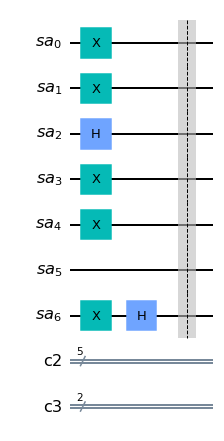

In [13]:
# First the channel from Alice to Bob

Sa = QuantumRegister(num_xor_total, "sa")
bob_rs = ClassicalRegister(len(one_idx))
bob_sec = ClassicalRegister(num_decoy)

circ_ab = QuantumCircuit(Sa, bob_rs, bob_sec)

j = 0 
l = 0 
for i in range(num_xor_total):
    
    if i not in decoy_a_idx:
        
        idx = one_idx[j]
        a = alice_mess[idx]
        k = idx%2
        encode_message(k, a, Sa[sa[i]], circ_ab)
        j = j + 1
    else:
        
        k = decoy_a_base[l]
        a = decoy_a_bit[l]
        encode_message(k, a, Sa[sa[i]], circ_ab)
        l = l + 1
        
circ_ab.barrier()
#Now eaves dropper action could be introduced here 

#between these comments
circ_ab.draw(output = "mpl")

Now the security of the Channel will be established by checking the decoy Bits

In [14]:

for i in range(num_decoy):
    
    idx = decoy_a_idx[i]
    base = decoy_a_base[i]
    
    if base == 1:
        circ_ab.h(Sa[sa[idx]])
    
    circ_ab.measure(Sa[sa[idx]], bob_sec[i])
    
circ_ab.barrier()

ct_ab = run_circuit(circ_ab, 1)
st_ab = count_to_str(ct_ab)
st_ab = st_ab[::-1]

chk_ab = st_ab[len(one_idx) + 1:]
flag = 1

for i in range(num_decoy):
    
    a = decoy_a_bit[i]
    c = (int)(chk_ab[i])
    
    if a != c: 
        flag = 0
        
if flag == 0:
    print("Security for Channel Alice to Bob Failed !")
else:
    print("Security for Channel Alice to Bob Passed !")

Security for Channel Alice to Bob Passed !


True
True


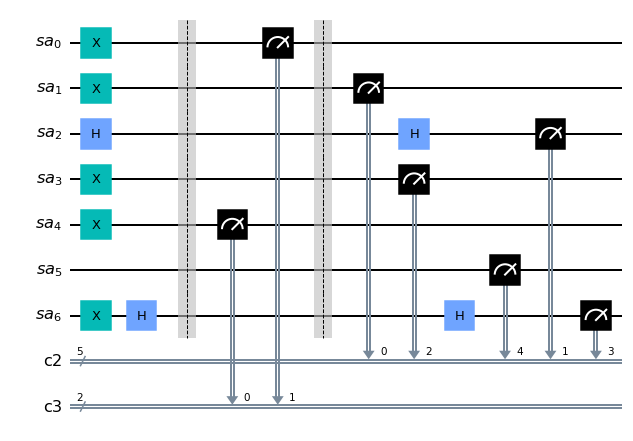

In [15]:
#Now as the security has been passed so Bob could proceed to decode the messages for him  
j = 0 
for i in range(num_xor_total):
    
    if i not in decoy_a_idx:
        idx = one_idx[j]
        if idx%2 == 1:
            circ_ab.h(Sa[sa[i]])
        circ_ab.measure(Sa[sa[i]], bob_rs[j])
        j = j + 1

count_ab = run_circuit(circ_ab, 1)
str_ab = count_to_str(count_ab)
str_ab = str_ab[::-1]

mess_ab = str_ab[:len(one_idx)]

for i in range(len(mess_ab)):
    
    idx = one_idx[i]
    dec_a_for_b[idx] = (int)(mess_ab[i])
    dec_c_for_b[idx] = dec_a_for_b[idx] ^ bob_xor[i]
    
print(compare(alice_mess, dec_a_for_b))
print(compare(charlie_mess, dec_c_for_b))

circ_ab.draw(output = "mpl")

Now the same above three 3 steps are being followed by Bob to Charlie where Bob sends his Qubits to charlie. 
<br> Charlie checks security of those and then decodes the message.

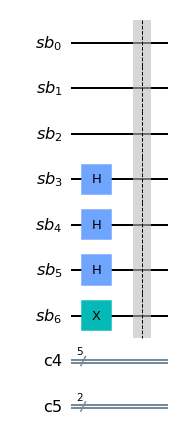

In [16]:
# Now the Qubits are generated by Bob and send to Charlie

Sb = QuantumRegister(num_xor_total, "sb")
charlie_rs = ClassicalRegister(len(one_idx))
charlie_sec = ClassicalRegister(num_decoy)

circ_bc = QuantumCircuit(Sb, charlie_rs, charlie_sec)

j = 0 
l = 0 
for i in range(num_xor_total):
    
    if i not in decoy_b_idx:
        
        idx = one_idx[j]
        b = bob_mess[idx]
        k = idx%2
        encode_message(k, b, Sb[sb[i]], circ_bc)
        j = j + 1
    else:
        
        k = decoy_b_base[l]
        b = decoy_b_bit[l]
        encode_message(k, b, Sb[sb[i]], circ_bc)
        l = l + 1
        
circ_bc.barrier()
#Now eaves dropper action could be introduced here 

#between these comments
circ_bc.draw(output = "mpl")

In [17]:
for i in range(num_decoy):
    
    idx = decoy_b_idx[i]
    base = decoy_b_base[i]
    
    if base == 1:
        circ_bc.h(Sb[sb[idx]])
    
    circ_bc.measure(Sb[sb[idx]], charlie_sec[i])
    
circ_bc.barrier()

ct_bc = run_circuit(circ_bc, 1)
st_bc = count_to_str(ct_bc)
st_bc = st_bc[::-1]

chk_bc = st_bc[len(one_idx) + 1:]
flag = 1

for i in range(num_decoy):
    
    b = decoy_b_bit[i]
    ch = (int)(chk_bc[i])
    
    if b != ch: 
        flag = 0
        
if flag == 0:
    print("Security for Channel Bob to Charlie Failed !")
else:
    print("Security for Channel Bob to Charlie Passed !")

Security for Channel Bob to Charlie Passed !


True
True


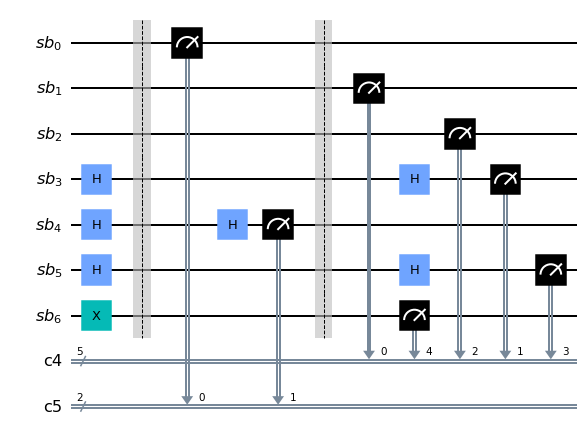

In [18]:
#Now as the security has been passed so Bob could proceed to decode the messages for him  
j = 0 
for i in range(num_xor_total):
    
    if i not in decoy_b_idx:
        idx = one_idx[j]
        if idx%2 == 1:
            circ_bc.h(Sb[sb[i]])
        circ_bc.measure(Sb[sb[i]], charlie_rs[j])
        j = j + 1

count_bc = run_circuit(circ_bc, 1)
str_bc = count_to_str(count_bc)
str_bc = str_bc[::-1]

mess_bc = str_bc[:len(one_idx)]

for i in range(len(mess_bc)):
    
    idx = one_idx[i]
    dec_b_for_c[idx] = (int)(mess_bc[i])
    dec_a_for_c[idx] = dec_b_for_c[idx] ^ charlie_xor[i]
    
print(compare(bob_mess, dec_b_for_c))
print(compare(alice_mess, dec_a_for_c))

circ_bc.draw(output = "mpl")

Now the last steps that is the channel between Charlie to Alice
<br> Here Charlie will prepare the qubits and will send those to Alice which will be similarly checked for security<br>
Then after verifying the security the messages will be decoded <br>

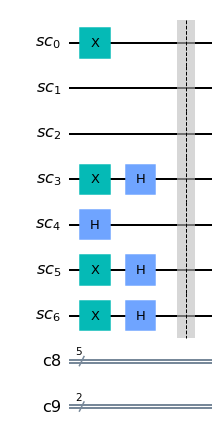

In [20]:
# Now the Qubits are generated by Charlie are sent to Alice

Sc = QuantumRegister(num_xor_total, "sc")
alice_rs = ClassicalRegister(len(one_idx))
alice_sec = ClassicalRegister(num_decoy)

circ_ca = QuantumCircuit(Sc, alice_rs, alice_sec)

j = 0 
l = 0 
for i in range(num_xor_total):
    
    if i not in decoy_c_idx:
        
        idx = one_idx[j]
        c = charlie_mess[idx]
        k = idx%2
        encode_message(k, c, Sc[sc[i]], circ_ca)
        j = j + 1
    else:
        
        k = decoy_c_base[l]
        c = decoy_c_bit[l]
        encode_message(k, c, Sc[sc[i]], circ_ca)
        l = l + 1
        
circ_ca.barrier()
#Now eaves dropper action could be introduced here 

#between these comments
circ_ca.draw(output = "mpl")

In [21]:
for i in range(num_decoy):
    
    idx = decoy_c_idx[i]
    base = decoy_c_base[i]
    
    if base == 1:
        circ_ca.h(Sc[sc[idx]])
    
    circ_ca.measure(Sc[sc[idx]], alice_sec[i])
    
circ_ca.barrier()

ct_ca = run_circuit(circ_ca, 1)
st_ca = count_to_str(ct_ca)
st_ca = st_ca[::-1]

chk_ca = st_ca[len(one_idx) + 1:]
flag = 1

for i in range(num_decoy):
    
    c = decoy_c_bit[i]
    ch = (int)(chk_ca[i])
    
    if c != ch: 
        flag = 0
        
if flag == 0:
    print("Security for Channel Charlie to Alice Failed !")
else:
    print("Security for Channel Charlie to Alice Passed !")

Security for Channel Charlie to Alice Passed !


True
True


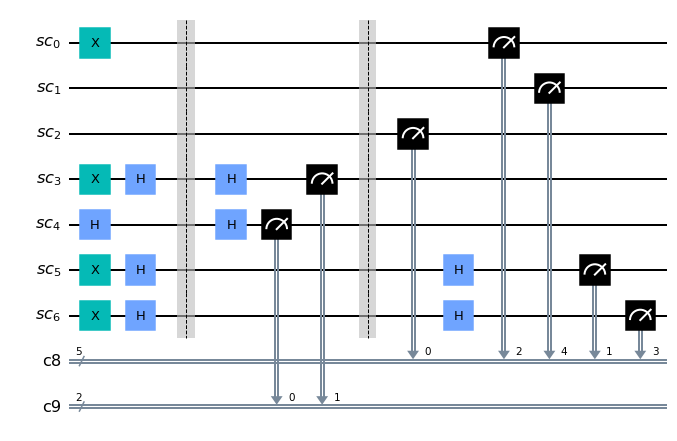

In [22]:
j = 0 
for i in range(num_xor_total):
    
    if i not in decoy_c_idx:
        idx = one_idx[j]
        if idx%2 == 1:
            circ_ca.h(Sc[sc[i]])
        circ_ca.measure(Sc[sc[i]], alice_rs[j])
        j = j + 1

count_ca = run_circuit(circ_ca, 1)
str_ca = count_to_str(count_ca)
str_ca = str_ca[::-1]

mess_ca = str_ca[:len(one_idx)]

for i in range(len(mess_ca)):
    
    idx = one_idx[i]
    dec_c_for_a[idx] = (int)(mess_ca[i])
    dec_b_for_a[idx] = dec_c_for_a[idx] ^ alice_xor[i]
    
print(compare(bob_mess, dec_b_for_a))
print(compare(charlie_mess, dec_c_for_a))

circ_ca.draw(output = "mpl")